In [78]:
import gensim
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd

In [99]:
# load pre-trained word2vec embeddings
# The embeddings can be downloaded from command prompt:
# wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

### top participating dimensions

In [50]:
top_k_words = []
zeros = 0.0
threshold = 0.001
h_dim = None
total = None
vectors = {}
embeddings = []
vocab = []
num = 5
width = 10

def load_vectors(filename):
    global vectors, dimensions, zeros, h_dim, total, top_k_words, embeddings, vocab
    vectors = {}
    zeros = 0.0
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    dimension = len(lines[0].split()) - 1
    top_k_words = [ [] for i in range(dimension)]
    c = 0
    for line in tqdm(lines):
        start = time.time()
        words = line.strip().split()
        vectors[words[0]] = [abs(float(i)) for i in words[1:]]
        vocab.append(words[0])
        embeddings.append([abs(float(i)) for i in words[1:]])
        h_dim = len(words[1:])
        c += 1
        vector = vectors[words[0]]
        for i, val in enumerate(vector):
            temp = top_k_words[i]
            if len(temp) < width:
                temp.append((val,words[0]))
            else:
                check = temp[-1]
                if check[0] < val:
                    temp[-1] = (val, words[0])
            top_k_words[i] = sorted(temp, reverse=True)
        zeros += sum([1 for i in vectors[words[0]] if i < threshold])
    print ("Sparsity =", 100. * zeros/(len(lines)*dimension))
    total = len(vectors)
    print ('done loading vectors')
    return embeddings, vocab


def load_top_dimensions(k):
    global top_k_words
    return
    dimensions = len(vectors[vectors.keys()[0]])
    for i in range(dimensions):
        temp = []
        while top_k_words[i].qsize() > 0:
            temp.append(top_k_words.get_nowait()[1])
        top_k_words[i] = temp
    print ('loaded top dimensions')
    return top_k_words


def find_top_participating_dimensions(word, k):
        if word not in vectors:
            print ('word not found')
            return []
        temp = [(j, i) for i, j in enumerate(vectors[word])]
        answer = []
        print (" -----------------------------------------------------")
        print ("Word of interest = " , word)
        for i, j in sorted(temp, reverse=True)[:k]:
            print ("The contribution of the word '%s' in dimension %d = %f" %(word, j, i))
            print ('Following are the top words in dimension', j, 'along with their contributions')
            print (top_k_words[j])
            answer.append([k[1] for k in top_k_words[j]])
        return

### get data of embeddings

In [5]:
import glob
txt_files = glob.glob("../data/external/*")
print(txt_files)

['../data/external/glove_original_15k_300d_train.txt', '../data/external/glove_original_3k_300d_val.txt', '../data/external/SPINE_glove.txt', '../data/external/SPINE_word2vec.txt', '../data/external/SPOWV_glove.txt', '../data/external/SPOWV_word2vec.txt', '../data/external/word2vec_original_15k_300d_train.txt', '../data/external/word2vec_original_3k_300d_val.txt']


In [51]:
weight_vals, weight_names = load_vectors("../data/external/word2vec_original_3k_300d_val.txt")

100%|██████████| 2000/2000 [00:02<00:00, 978.21it/s] 

Sparsity = 0.4841666666666667
done loading vectors


In [52]:
np.shape(weight_vals)

(2000, 300)

In [54]:
pca = PCA(0.95)
pca.fit(weight_vals)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [116]:
pca.explained_variance_ratio_[:10]

array([0.08979994, 0.01155926, 0.01049218, 0.00921818, 0.00863043,
       0.00798783, 0.00746602, 0.00740001, 0.00697703, 0.00678535])

In [56]:
len(pca.explained_variance_ratio_)

259

In [58]:
principal_components = pca.fit_transform(weight_vals)
print(np.shape(principal_components))

(2000, 259)


In [65]:
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(4,100))

<IPython.core.display.Javascript object>


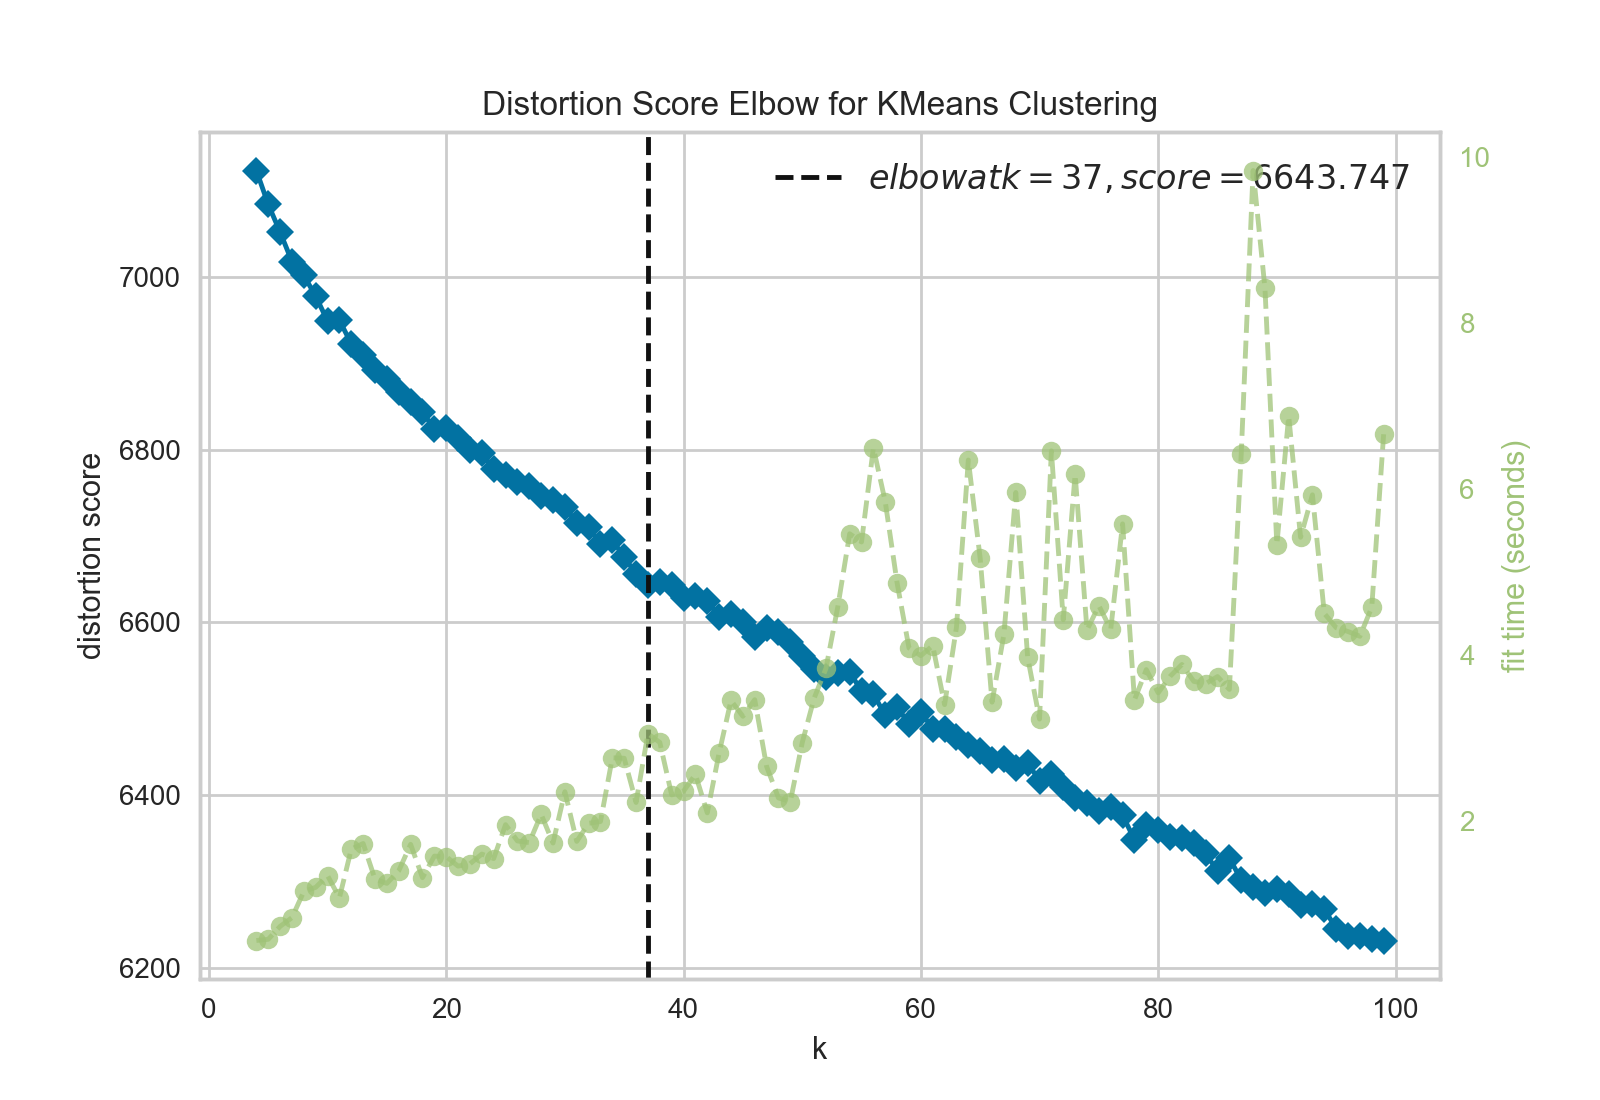

In [66]:
visualizer.fit(principal_components)
visualizer.show()

### k-means

In [68]:
km = KMeans(n_clusters=37)
km.fit(principal_components)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=37, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [72]:
km.labels_

array([ 0, 28, 16, ..., 10, 10,  0], dtype=int32)

In [75]:
km_labels_with_original = list(zip(weight_names, km.labels_))

In [79]:
df = pd.DataFrame(
    data={
        'word': weight_names,
        'assignment': km.labels_
    }
)
df.head()

,assignment,word
0,0,secondly
1,28,entropy
2,16,nwa
3,11,preface
4,28,semantic


In [101]:
df[df["assignment"] == 5].head()

,assignment,word
41,5,coefficient
71,5,trojans
80,5,tna
137,5,fonts
143,5,durability


In [102]:
weight_names[:10]

['secondly',
 'entropy',
 'nwa',
 'preface',
 'semantic',
 'centimeter',
 'trolley',
 'muzzle',
 'sanford',
 'aug']

In [122]:
load_top_dimensions(259)

In [148]:
find_top_participating_dimensions("mathematics", 5)

word not found


[]

### plot closest words

In [129]:
def display_closest_words(model, word, n_components, do_pca=False, topn=259):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word, topn=topn)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in tqdm(close_words):
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    if do_pca:
        pca = PCA(0.95)
        # use only principal components
        arr = pca.fit_transform(arr)
        
    # find kmeans coords for n dimensions
    km = KMeans(n_clusters=n_components, random_state=0)
    np.set_printoptions(suppress=True)
    Y = km.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.clf()
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [103]:
model.similar_by_word('nocturnal')

[('nocturnal_animals', 0.6356192827224731),
 ('nocturnal_creatures', 0.6093026995658875),
 ('nighttime', 0.595292329788208),
 ('crepuscular', 0.5910230278968811),
 ('Nocturnal', 0.5759037137031555),
 ('diurnal', 0.5710632801055908),
 ('nocturnal_creature', 0.5645543336868286),
 ('nocturnal_predators', 0.5561679601669312),
 ('Carpet_Python', 0.5230515003204346),
 ('noctural', 0.5090683698654175)]

100%|██████████| 259/259 [00:00<00:00, 861.49it/s]


<IPython.core.display.Javascript object>


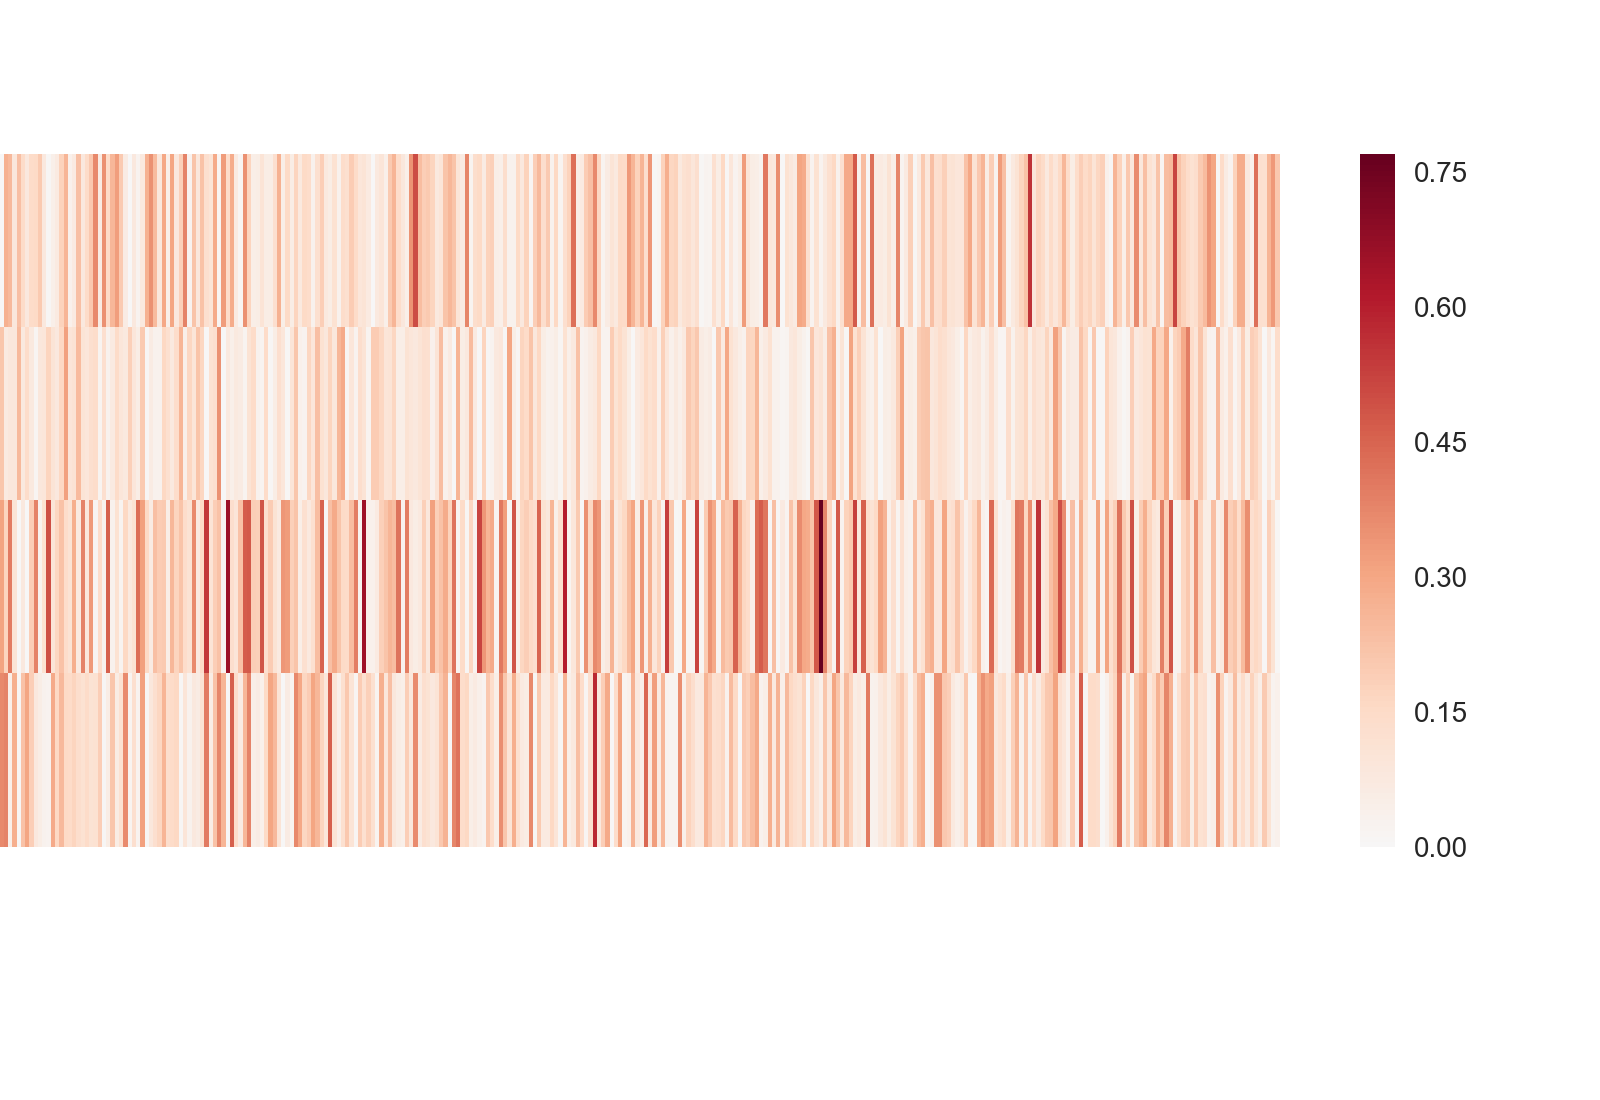

In [145]:
display_closest_words(model, 'nocturnal', 37)

In [132]:
display_closest_words(model, 'nocturnal', 37, do_pca=True)

100%|██████████| 259/259 [00:00<00:00, 689.48it/s]


### heatmap

In [143]:
import seaborn as sns

In [140]:
vectors.keys()

dict_keys(['secondly', 'entropy', 'nwa', 'preface', 'semantic', 'centimeter', 'trolley', 'muzzle', 'sanford', 'aug', 'ventral', 'periodicals', 'endings', 'originality', 'gupta', 'immature', 'conjecture', 'collaborate', 'blanket', 'misunderstanding', 'vase', 'replication', 'summarized', 'elevations', 'differentiated', 'basics', 'upload', 'soundtracks', 'greenish', 'stereotypical', 'razed', 'aides', 'nair', 'approximation', 'friendships', 'sterile', 'expressive', 'boogie', 'revolver', 'barony', 'nes', 'coefficient', 'governorship', 'zack', 'jasmine', 'ramps', 'pluto', 'lpga', 'stevie', 'biking', 'vulnerability', 'symmetrical', 'anarchist', 'fathered', 'ventured', 'appropriately', 'topography', 'elaborated', 'remodeled', 'neutrons', 'remnant', 'unitary', 'romantically', 'swings', 'thursdays', 'm1', 'slaughtered', 'churchyard', 'warp', 'pierced', 'deciduous', 'trojans', 'outdated', 'latent', 'rin', 'philanthropic', 'superstructure', 'mammalian', 'suggestive', 'grover', 'tna', 'criticizing'

In [141]:
words = ['nocturnal', 'secondly','revolver','boogie']
words_weight_heatmap = np.array(list(map(lambda w: vectors[w], words)))

In [146]:
plt.clf()
ax = sns.heatmap(words_weight_heatmap, cmap='RdBu_r', center=0, xticklabels=0)
# ax = sns.heatmap(words_svd, cmap=sns.diverging_palette(0, 255, sep=32, n=256), center=0, xticklabels=0)
plt.subplots_adjust(left=0, right=1, top=0.86, bottom=0.23)
ax.set_yticklabels(words,rotation='horizontal',fontsize=12)
# plt.savefig('heatmap_svd.png', format='png',dpi=300)
plt.show()